In [1]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import bz2
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from random import randrange
from bertopic import BERTopic
from sklearn.preprocessing import OneHotEncoder
import re
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import src.utils as utils
import src.feature_extraction as feature_extraction
import src.plot as plot

In [2]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")

In [3]:
from IPython.display import display
VIRAL_THR = 50

In [4]:
@utils.cache_to_file_pickle("function-make_features_labels_arrays", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
def make_features_labels_arrays(preprocessed_dataset_file_path, batch_size = 1000000):
    
    def process_batch(features, quotation_topic, num_occurrences,
                      features_batch, quotations_batch, num_occurrences_batch):
                
        # If list is empty, don't do anything otherwise BERTopic raises un exception.
        if features_batch:
            topics, _ = bert_model.transform(quotations_batch)

            # Convert sparse list of lists to COO sparse matrix. 
            # COO sparse matrices have the advantage of being quick to generate and to stack.
            features.append( scipy.sparse.coo_matrix(features_batch) )

            # These can simply be added at the end of the list as they are not sparse.
            quotation_topic.extend( topics )
            num_occurrences.extend( num_occurrences_batch )

        return features, quotation_topic, num_occurrences
    
    features_cols_titles = None
    
    features = []
    quotation_topic = []
    num_occurrences = []
    
    features_batch = []
    quotations_batch = []
    num_occurrences_batch = []
        
    for line in utils.json_lines_generator(preprocessed_dataset_file_path):        
        num_occurrences_batch.append(line.pop('num_occurrences'))
        quotations_batch.append(line.pop('quotation'))
        
        if features_cols_titles is None:
            features_cols_titles = sorted(line)

        features_batch.append([line[key] for key in features_cols_titles])
        
        if len(features_batch) >= batch_size:
            features, quotation_topic, num_occurrences = process_batch(features, quotation_topic, num_occurrences,
                                                                       features_batch, quotations_batch, num_occurrences_batch)
            features_batch = []
            quotations_batch = []
            num_occurrences_batch = []
            
    features, quotation_topic, num_occurrences = process_batch(features, quotation_topic, num_occurrences,
                                                               features_batch, quotations_batch, num_occurrences_batch)

    # Merge list of sparse matrices into a single sparse matrix.
    # Here COO sparse format is useful because this stacking is done faster than with other formats.
    features = scipy.sparse.vstack(features)
    
    # Convert list to a single numpy array.
    quotation_topic = np.array(quotation_topic)
    num_occurrences = np.array(num_occurrences)
        
    # One-hot encode quotation topics.
    topic_number_names_map = bert_model.get_topic_info().set_index('Topic')
    topic_number_names_map.at[-1, 'Name'] = 'unknown'

    quotation_topic_names = topic_number_names_map.loc[quotation_topic, 'Name'].values
    
    encoder = OneHotEncoder(sparse = True, dtype = 'int')
    one_hot_quotation_topics = encoder.fit_transform(np.reshape(quotation_topic_names, (-1, 1)))
    
    # Add quotation topics as columns of feature matrix.
    features = scipy.sparse.hstack([features, one_hot_quotation_topics])
    encoder_categories, = encoder.categories_
    features_cols_titles.extend([f'quotation_topic_{col_name.upper()}' for col_name in encoder_categories])
     
    # Convert sparse matrix from COO to CSR format for easy slicing later on.
    features = features.tocsr()
    
    return features, num_occurrences, features_cols_titles

In [5]:
features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)

<a id='stratified_train_test_split'></a>
## 3.B.a Splitting Data into Training and Testing in a Stratified Manner
[Back to table of content](#table_of_contents)

In [6]:
# Seed numpy for reproducibility of all following code.
np.random.seed(0x616461)

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC

In [8]:
viral_label = np.int32(num_occurrences > VIRAL_THR)

splits = train_test_split(features, num_occurrences, viral_label,
                          test_size = 0.3,
                          shuffle = True,
                          stratify = viral_label)
                                                  
features_train, features_test, num_occurrences_train, num_occurrences_test, viral_label_train, viral_label_test = splits

# Cleanup temporary variables.
del splits, features, num_occurrences, viral_label

<a id='classification_feature_selection'></a>
## 3.B.b Feature Selection for Classification
[Back to table of content](#table_of_contents)

In [9]:
def sweep_l1_regularization(features, labels, cv_n_splits = 10, downsampling_factor = 'lowest',
                            l1_log_min = -5, l1_log_max = 2, l1_log_steps = 50):

    allowed_print_warning = True
    if downsampling_factor == 'lowest':
        allowed_print_warning = False
        downsampling_factor = 1
    
    # Estimate number of samples of each class needed.
    num_samples_per_class = len(labels) // (2 * downsampling_factor)
    
    # Get number of samples available for smaller class.
    num_positive_samples = np.sum(labels)    
    num_samples_smaller_class = min(num_positive_samples, len(labels) - num_positive_samples)    
    
    if allowed_print_warning and num_samples_smaller_class < num_samples_per_class:
        print(f"[WARNING]: Requested downsampling_factor of {downsampling_factor} with {len(labels)} samples. " + \
              f"This would require {num_samples_per_class} samples per class, but minority class only has " + \
              f"{num_samples_smaller_class} samples. Using {2 * num_samples_smaller_class} samples to train per " + \
              f"class instead.\n\n")
    
    # Split training samples into balanced classes.    
    idx_positive_samples, = np.where(labels == 1)
    idx_negative_samples, = np.where(labels == 0)
    
    idx_positive_samples = np.random.choice(idx_positive_samples, size = num_samples_smaller_class, replace = False)
    idx_negative_samples = np.random.choice(idx_negative_samples, size = num_samples_smaller_class, replace = False)

    all_idx = list(idx_positive_samples) + list(idx_negative_samples)
    
    features = features[all_idx]
    labels   = labels  [all_idx]
    
    print(f"Training on {len(labels)} samples with {features.shape[1]} features")
    
    res = GridSearchCV(estimator  = LinearSVC(dual = False, max_iter = 10000), 
                       param_grid = {'penalty': ('l1', 'l2'), 'C': np.logspace(l1_log_min, l1_log_max, l1_log_steps)},
                       cv         = StratifiedKFold(cv_n_splits),
                       scoring    = {'accuracy' : 'accuracy',
                                     'precision': 'precision',
                                     'recall'   : 'recall',
                                     'f1'       : 'f1',
                                     'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8)}, 
                       return_train_score = True,
                       refit = False,
                       n_jobs = 8,
                       verbose = 2).fit(features, labels)

    df = pd.DataFrame(res.cv_results_)
    df = df[[col for col in df.columns if col.startswith('param_') or re.match(r'^(mean|std)_(train|test)_', col)]]

    # Changing names of sparsity columns and dropping duplicates.
    df = df.drop(columns = ['mean_test_sparsity', 'std_test_sparsity']).rename(columns = {'mean_train_sparsity': 'mean_sparsity',
                                                                                          'std_train_sparsity' : 'std_sparsity'})
    return df, all_idx

In [10]:
df, all_idx = sweep_l1_regularization(features_train, viral_label_train)

Training on 1044982 samples with 613 features
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [11]:
df

,param_C,param_penalty,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_precision,std_test_precision,mean_train_precision,std_train_precision,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_sparsity,std_sparsity
0,0.00001,l1,0.585250,0.001065,0.585228,0.000180,0.650718,0.002415,0.650706,0.000447,0.368083,0.001326,0.367996,0.001521,0.470193,0.001195,0.470119,0.001131,0.996737,1.110223e-16
1,0.00001,l2,0.596276,0.001455,0.596376,0.000209,0.606173,0.001673,0.606285,0.000236,0.549678,0.002567,0.549762,0.000806,0.576542,0.001796,0.576641,0.000440,0.013051,1.734723e-18
2,0.000014,l1,0.585558,0.001167,0.585545,0.000120,0.645419,0.002210,0.645401,0.000487,0.379746,0.001641,0.379716,0.000915,0.478156,0.001585,0.478128,0.000616,0.996737,1.110223e-16
3,0.000014,l2,0.597182,0.001459,0.597233,0.000228,0.607230,0.001623,0.607292,0.000261,0.550333,0.002988,0.550355,0.000778,0.577379,0.001991,0.577423,0.000434,0.013051,1.734723e-18
4,0.000019,l1,0.586815,0.001321,0.586815,0.000147,0.631047,0.002080,0.631045,0.000231,0.418055,0.001793,0.418055,0.000199,0.502928,0.001734,0.502929,0.000193,0.996737,1.110223e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,51.794747,l2,0.609723,0.001913,0.610599,0.000222,0.616360,0.002203,0.617265,0.000653,0.581225,0.003023,0.582188,0.002399,0.598273,0.002130,0.599210,0.001003,0.013051,1.734723e-18
96,71.968567,l1,0.609740,0.001901,0.610606,0.000216,0.616364,0.002185,0.617266,0.000649,0.581294,0.003035,0.582223,0.002396,0.598311,0.002127,0.599228,0.001001,0.013214,4.893964e-04
97,71.968567,l2,0.609705,0.001921,0.610604,0.000224,0.616330,0.002208,0.617261,0.000650,0.581248,0.003020,0.582233,0.002368,0.598271,0.002135,0.599232,0.000989,0.013051,1.734723e-18
98,100.0,l1,0.609739,0.001893,0.610602,0.000219,0.616362,0.002175,0.617259,0.000652,0.581298,0.003031,0.582231,0.002393,0.598312,0.002122,0.599230,0.001000,0.013051,1.734723e-18


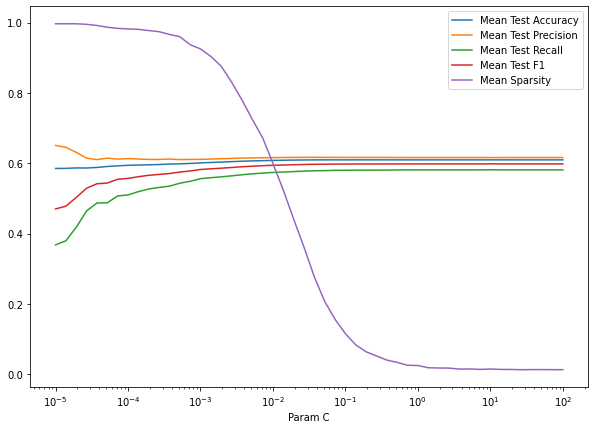

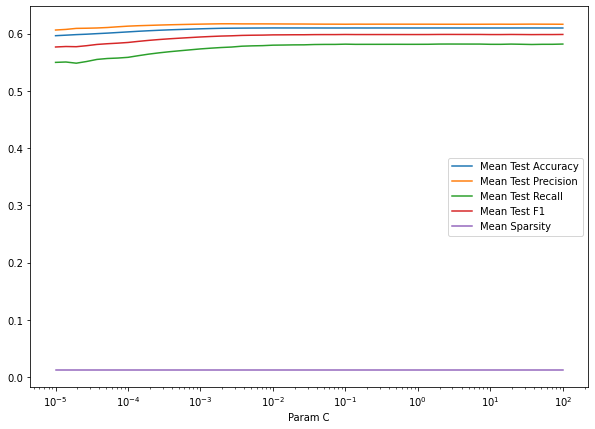

In [12]:
def plot_columns_over_column(df, x_axis_column, y_axis_columns, x_log_scale = True, figsize = (10, 7)):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    
    if x_log_scale:
        ax.set(xscale = 'log')
    
    for y in y_axis_columns:        
        ax.plot(df[x_axis_column], df[y], label = y.replace('_', ' ').title())
        
    plt.xlabel(x_axis_column.replace('_', ' ').title())
    plt.legend()
    plt.show()
    
plot_columns_over_column(df[df['param_penalty'] == 'l1'], 'param_C', [col for col in df.columns if col.startswith('mean_test_')] + ['mean_sparsity'])
plot_columns_over_column(df[df['param_penalty'] == 'l2'], 'param_C', [col for col in df.columns if col.startswith('mean_test_')] + ['mean_sparsity'])

<a id='training_regression'></a>
# 4. Regressing number of occurences

<a id='theory_reg'></a>
## 4.A. Theoretical explanations of the methods used to perform the regression
[Back to table of content](#table_of_contents)

In this section, we will describe the mathematical models/concepts of the machine learning methods we will use in order to regress the occurrence of a quote from some features previously selected. 

We will focus on a simple regression method: linear regression.

<a id='lin_reg_theory'></a>
### 4.A.a. Linear Regression

Regression problems are problems aiming at finding a function $f$ that estimates the relationship between categorical or continuous inputs and an output continuous variable.

Linear regression is a specific modelling technique to resolve regression problems. Specifically, it is a model in which we assume that the output variable can be predicted from a linear combination of the input variables such that: 

$$Y = f(X) = \alpha_0 + x_1\alpha_1 ... + x_n\alpha_n$$

Training of the model aims to find the coefficients $\alpha_i$. To find these, we typically minimize the mean squared error (MSE) defined as follows:

$$L_{MSE}(\alpha; x_i, y_i) = (y_i - f(\alpha; x_i))^2$$

We will also try to add $L2$ or $L1$ regularization terms to push the less meaningful terms towards 0 which will improve the interpretability of the results. In case of the linear regression with no regularization or with $L2$ regularization the solution has a closed-form. For $L1$ regularization there is no closed-form solution. When a closed-form solution is not available, linear regression can be solved via gradient descent. Even if a closed-form solution is available, it should be noted that it may require large amounts of memory to be computed for large training sets.

We want to start with linear regression for multiple reasons. The first one is that it is a simple, easy-to-train model which will allow us to handle bigger subsets of the dataset for training in a reasonable time. It's also interesting to see if linear relationships are enough to achieve rather good accuracy for such a complex dataset and it will constitute a good indicator as to whether low bias can be achieved with such a low complexity model.

For this model to be acceptable, there are some assumptions:
- The relationship between $X$ and $Y$ (features and quote count popularity) are linearly related. This might not be the case but we want to see if it is by gauging the accuracy of the model.

- The observations are independent of each other. Of course, this can never truly be the case in such a huge dataset influenced by extremely popular extremely quoted individuals, real-world events, and a ton of other params but we still think that we can apply this model with some amount of success.